In [66]:
# Imports
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19

from scipy.optimize import fmin_l_bfgs_b

import tensorflow as tf
assert tf.__version__[0] == '1', 'tensorflow version 1 is required'

# from google.colab import drive
# drive.mount('/content/drive')

In [69]:
# Hyperparams
ITERATIONS = 10
CHANNELS = 3
IMAGE_SIZE = 500
IMAGE_WIDTH = IMAGE_SIZE
IMAGE_HEIGHT = IMAGE_SIZE
IMAGENET_MEAN_RGB_VALUES = [123.68, 116.779, 103.939]
CONTENT_WEIGHT = 0.02
STYLE_WEIGHT = 4.5
TOTAL_VARIATION_WEIGHT = 0.995
TOTAL_VARIATION_LOSS_FACTOR = 1.25

In [85]:
# Paths
input_image_path = "input.png"
style_image_path = "style.png"
output_image_path = "output.png"
combined_image_path = "combined.png"
noise_image_path = "noise.png"
# input_image_path = "drive/My Drive/AIschool Team4/유제훈/input.png"
# style_image_path = "drive/My Drive/AIschool Team4/유제훈/style.png"
# output_image_path = "drive/My Drive/AIschool Team4/유제훈/output.png"
# combined_image_path = "drive/My Drive/AIschool Team4/유제훈/combined.png"
# noise_image_path = "drive/My Drive/AIschool Team4/유제훈/noise.png"

# San Francisco
san_francisco = "https://www.economist.com/sites/default/files/images/print-edition/20180602_USP001_0.jpg"

# Warsaw by Tytus Brzozowski, http://t-b.pl
tytus = "http://meetingbenches.com/wp-content/flagallery/tytus-brzozowski-polish-architect-and-watercolorist-a-fairy-tale-in-warsaw/tytus_brzozowski_13.jpg"

C_path = san_francisco
S_path = tytus

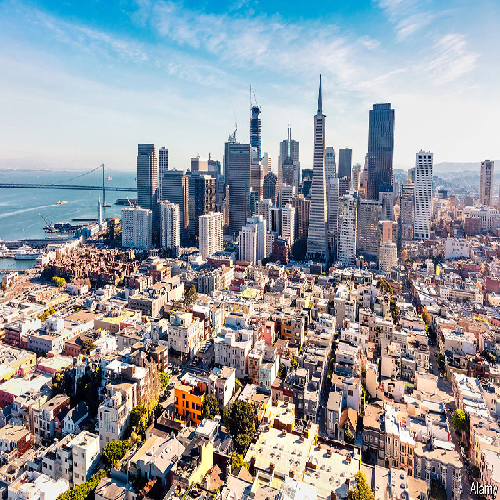

In [72]:
#Input visualization 
input_image = Image.open(BytesIO(requests.get(C_path).content))
input_image = input_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
input_image.save(input_image_path)
input_image

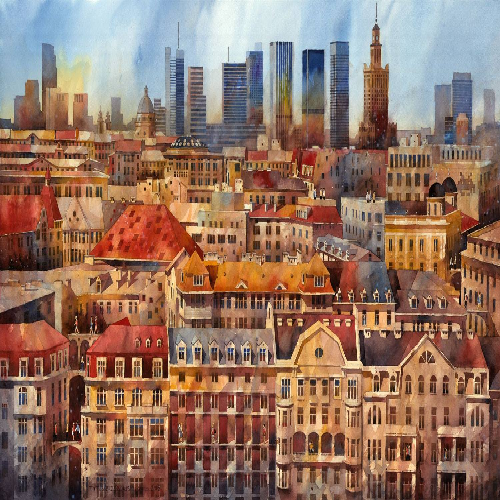

In [73]:
# Style visualization 
style_image = Image.open(BytesIO(requests.get(S_path).content))
style_image = style_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
style_image.save(style_image_path)
style_image

In [74]:
'''Data normalization and reshaping from RGB to BGR'''
# Batch Normalization and Instance Normalization
input_image_array = np.asarray(input_image, dtype="float32") # shape == (500, 500, 3)
input_image_array = np.expand_dims(input_image_array, axis=0) # shape == (1, 500, 500, 3)

input_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2] # normalization
input_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
input_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
input_image_array = input_image_array[:, :, :, ::-1] # reshaping

style_image_array = np.asarray(style_image, dtype="float32") # shape == (500, 500, 3)
style_image_array = np.expand_dims(style_image_array, axis=0) # shape == (1, 500, 500, 3)

style_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2] # normalization
style_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
style_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
style_image_array = style_image_array[:, :, :, ::-1] # reshaping

# print(input_image_array) # how to visualize?

In [75]:
'''Model'''
input_image = backend.variable(input_image_array) # content image variable | shape == (1, 500, 500, 3)
style_image = backend.variable(style_image_array) # style image variable | shape == (1, 500, 500, 3)
combination_image = backend.placeholder((1, IMAGE_HEIGHT, IMAGE_SIZE, 3)) # placeholder..? | shape == (1, 500, 500, 3)
### Fully understanding of backend.variable and backend.placeholder might be required
### I don't know how to print value of input_image and style_image

input_tensor = backend.concatenate([input_image,style_image,combination_image], axis=0)
#                      concatenated in order of content(0), style(1), noise(2)
model = VGG16(input_tensor=input_tensor, include_top=False) # WARNING : VGG16
# model = VGG19(input_tensor=input_tensor, include_top=False)

In [84]:
'''define functions'''
### I don't understand why backend is used.
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

def compute_style_loss(style, combination):
    style = gram_matrix(style)
    combination = gram_matrix(combination)
    size = IMAGE_HEIGHT * IMAGE_WIDTH
    return backend.sum(backend.square(style - combination)) / (4. * (CHANNELS ** 2) * (size ** 2))

def total_variation_loss(x):
    '''
    x : combination_image (== noise image)
    combination_image = backend.placeholder((1, IMAGE_HEIGHT, IMAGE_SIZE, 3)) # placeholder..? | shape == (1, 500, 500, 3)
    what is placeholder?
    '''
    a = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, 1:, :IMAGE_WIDTH-1, :])
    b = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, :IMAGE_HEIGHT-1, 1:, :])
    return backend.sum(backend.pow(a + b, TOTAL_VARIATION_LOSS_FACTOR))

def evaluate_loss_and_gradients(x):
    x = x.reshape((1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    outs = backend.function([combination_image], outputs)([x]) ### backend.function..?
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return loss, gradients

class Evaluator:

    def loss(self, x):
        loss, gradients = evaluate_loss_and_gradients(x)
        self._gradients = gradients
        return loss

    def gradients(self, x):
        return self._gradients

def visualx(x):
    x = x.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    x = x[:, :, ::-1]
    x[:, :, 0] += IMAGENET_MEAN_RGB_VALUES[2]
    x[:, :, 1] += IMAGENET_MEAN_RGB_VALUES[1]
    x[:, :, 2] += IMAGENET_MEAN_RGB_VALUES[0]
    x = np.clip(x, 0, 255).astype("uint8")
    output_image = Image.fromarray(x)
    return output_image

In [81]:
'''content loss'''
layers = dict([(layer.name, layer.output) for layer in model.layers])
### WARNING : input tensor shape == (3, 500, 500, 3) (concatenated)
print(layers)
# print(backend.eval(layers['input_9']))

content_layer = "block2_conv2" # which layer to be used for content_loss
layer_features = layers[content_layer] # output of content_layer
content_image_features = layer_features[0, :, :, :] # feature map of content image in block2_conv2 (== content_layer)
combination_features = layer_features[2, :, :, :] # feature map of noise iamge in block2_conv2 (== content_layer)

# print(content_image_features) # (250, 250, 128) if layer == block2_conv2
# print(combination_features) # (250, 250, 128) if layer == block2_conv2

loss = backend.variable(0.)
loss += CONTENT_WEIGHT * content_loss(content_image_features, combination_features)

'''style loss'''
style_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]
for layer_name in style_layers:
    layer_features = layers[layer_name] # output of style_layers
    style_features = layer_features[1, :, :, :] # feature map of style image
    combination_features = layer_features[2, :, :, :] # feature map of noise image
    style_loss = compute_style_loss(style_features, combination_features)
    loss += (STYLE_WEIGHT / len(style_layers)) * style_loss
# current loss == (CONTENT_WEIGHT * content_loss) + (STYLE_WEIGHT / len(style_layers) * style_loss)

'''total variation loss'''
loss += TOTAL_VARIATION_WEIGHT * total_variation_loss(combination_image)
# current loss == content loss and style loss + (TOTAL_VARIATION_WEIGHT * total_variation_loss)
### what if TOTAL_VARIATION_WEIGHT = 0?

outputs = [loss] ### what's this?
outputs += backend.gradients(loss, combination_image)
print(outputs)

evaluator = Evaluator()

W0810 13:05:19.441504  9240 variables.py:2429] Variable += will be deprecated. Use variable.assign_add if you want assignment to the variable value or 'x = x + y' if you want a new python Tensor object.


{'input_10': <tf.Tensor 'concat_9:0' shape=(3, 500, 500, 3) dtype=float32>, 'block1_conv1': <tf.Tensor 'block1_conv1_9/Relu:0' shape=(3, 500, 500, 64) dtype=float32>, 'block1_conv2': <tf.Tensor 'block1_conv2_9/Relu:0' shape=(3, 500, 500, 64) dtype=float32>, 'block1_pool': <tf.Tensor 'block1_pool_9/MaxPool:0' shape=(3, 250, 250, 64) dtype=float32>, 'block2_conv1': <tf.Tensor 'block2_conv1_9/Relu:0' shape=(3, 250, 250, 128) dtype=float32>, 'block2_conv2': <tf.Tensor 'block2_conv2_9/Relu:0' shape=(3, 250, 250, 128) dtype=float32>, 'block2_pool': <tf.Tensor 'block2_pool_9/MaxPool:0' shape=(3, 125, 125, 128) dtype=float32>, 'block3_conv1': <tf.Tensor 'block3_conv1_9/Relu:0' shape=(3, 125, 125, 256) dtype=float32>, 'block3_conv2': <tf.Tensor 'block3_conv2_9/Relu:0' shape=(3, 125, 125, 256) dtype=float32>, 'block3_conv3': <tf.Tensor 'block3_conv3_9/Relu:0' shape=(3, 125, 125, 256) dtype=float32>, 'block3_pool': <tf.Tensor 'block3_pool_9/MaxPool:0' shape=(3, 62, 62, 256) dtype=float32>, 'block

In [64]:
'''def display_feature_map(feature_maps, col_size, row_size, featuremap_index): 
#     activation = feature_maps[featuremap_index]
    activation = feature_maps
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size)
    for row in range(0,row_size):
        for col in range(0,col_size):
#             ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            ax.imshow(activation[0, :, :, :], cmap='gray')
            activation_index += 1
#     fig.savefig('plot.png')
    fig.show()

layer_outputs = [layer.output for layer in model.layers]
visualize_model = Model(inputs=model.input, outputs=layer_outputs)
feature_maps = visualize_model.predict(layers['block2_conv2'], steps=0)
# display_feature_map(feature_maps, 1, 1, 0)
plt.imshow(feature_maps[:])
'''

"def display_feature_map(feature_maps, col_size, row_size, featuremap_index): \n#     activation = feature_maps[featuremap_index]\n    activation = feature_maps\n    activation_index=0\n    fig, ax = plt.subplots(row_size, col_size)\n    for row in range(0,row_size):\n        for col in range(0,col_size):\n#             ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')\n            ax.imshow(activation[0, :, :, :], cmap='gray')\n            activation_index += 1\n#     fig.savefig('plot.png')\n    fig.show()\n\nlayer_outputs = [layer.output for layer in model.layers]\nvisualize_model = Model(inputs=model.input, outputs=layer_outputs)\nfeature_maps = visualize_model.predict(layers['block2_conv2'], steps=0)\n# display_feature_map(feature_maps, 1, 1, 0)\nplt.imshow(feature_maps[:])\n"

In [83]:
conv_layer = [layer.name for layer in model.layers]
del conv_layer[0]
print(conv_layer)

for conv_name in conv_layer:
    conv_name = str(conv_name)
#     conv_image_path = "drive/My Drive/AIschool Team4/유제훈/conv_image/{}.png".format(conv_name)
    conv_image_path = "conv_image/{}.png".format(conv_name)
    
    conv_features = layers[conv_name]
    content_image_features = conv_features[0, :, :, :]
    combination_features = conv_features[2, :, :, :]

['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']


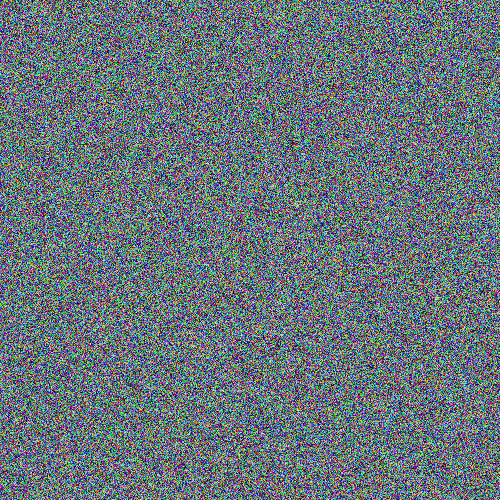

In [86]:
x = np.random.uniform(0, 255, (1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)) - 128. # noise image??n
noise_image = visualx(x)
noise_image.save(noise_image_path)
noise_image

Iteration 0 completed with loss 104268742656
Iteration 1 completed with loss 42760560640
Iteration 2 completed with loss 29081704448
Iteration 3 completed with loss 24836882432
Iteration 4 completed with loss 22888292352
Iteration 5 completed with loss 22061619200
Iteration 6 completed with loss 21555322880
Iteration 7 completed with loss 21276739584
Iteration 8 completed with loss 21093703680
Iteration 9 completed with loss 20947339264


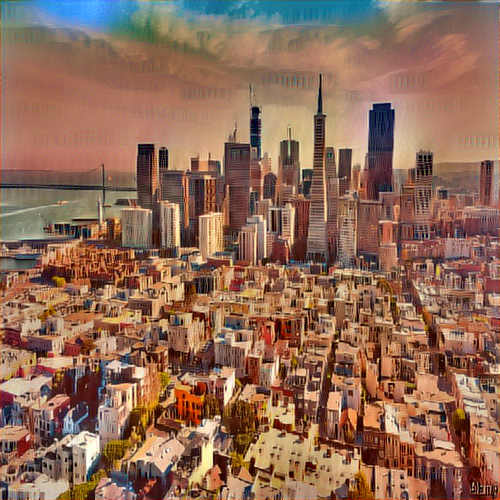

In [13]:
for i in range(ITERATIONS):
    x, loss, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.gradients, maxfun=20)
    print("Iteration %d completed with loss %d" % (i, loss))
    
x = x.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
x = x[:, :, ::-1]
x[:, :, 0] += IMAGENET_MEAN_RGB_VALUES[2]
x[:, :, 1] += IMAGENET_MEAN_RGB_VALUES[1]
x[:, :, 2] += IMAGENET_MEAN_RGB_VALUES[0]
x = np.clip(x, 0, 255).astype("uint8")
output_image = Image.fromarray(x)
output_image.save(output_image_path)
output_image

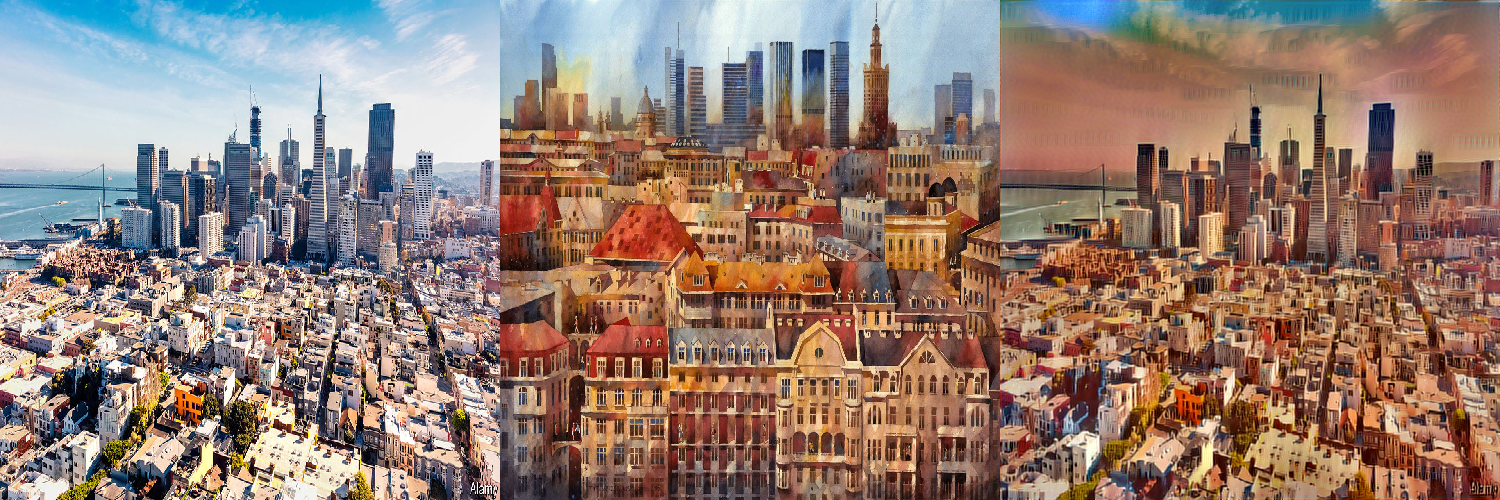

In [14]:
# Visualizing combined results
combined = Image.new("RGB", (IMAGE_WIDTH*3, IMAGE_HEIGHT))
x_offset = 0
for image in map(Image.open, [input_image_path, style_image_path, output_image_path]):
    combined.paste(image, (x_offset, 0))
    x_offset += IMAGE_WIDTH
combined.save(combined_image_path)
combined